In this notebook I want to explore basic image manipulation.

In [1]:
using Images, TestImages, Colors, FileIO;

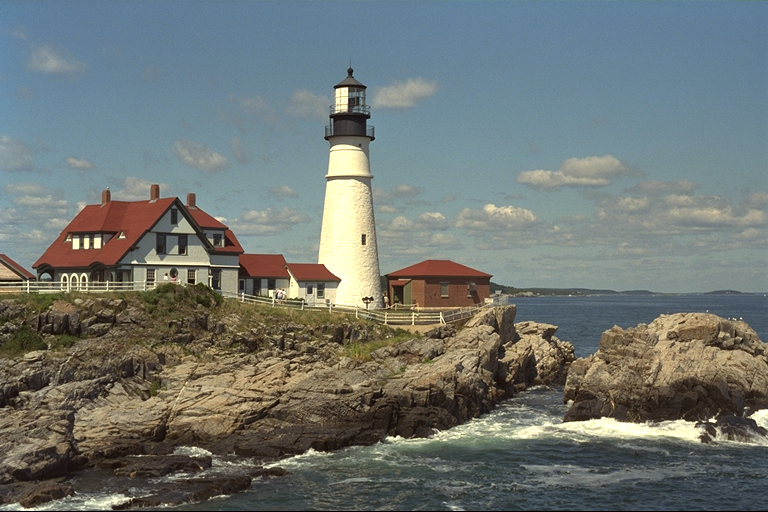

In [77]:
img = testimage("lighthouse")

I will implement a blurring function as the primary objective.

One fundamental concept in computational photography: iterate over the output to generate the appropriate input to use.

Steps in blurring an image:

2. Generate a kernel
1. Allocate a new image (blurring can't be an in-place operation because an input pixel is used multiple times
3. Iterate over the output and calculate the kernel

I am also curious to see the effects of different methods on the timing of the entire program.

## Generating kernels

I want to generate a few custom types (like structs in C++ or enum types in Python 3) to make data manipulation a little bit easier.

I tried to make a type called `size`, but got this error message. It looks like there is another method defined in the images packages - actually 139 of them! No matter, I will define a new type with a different name!

In [3]:
length(methods(size))

139

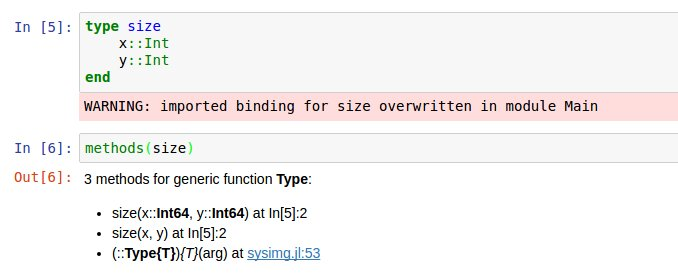

In [4]:
load("04-overwrite-main.jpg")

In [5]:
type coord
    x::Int
    y::Int
end

In [6]:
methods(coord)

# 3 methods for generic function "(::Type)":
coord(x::Int64, y::Int64) at In[5]:2
coord(x, y) at In[5]:2
(::Type{T}){T}(arg) at sysimg.jl:53

An interesting feature of Julia types is that they define default function constructors for a type, hence the output of the `methods` function above.

In the process of creating a function to generate a kernel in 2 dimensions, I want to generate a 1D gaussian. I can do this with an anonymous function. Even cooler, variable names in Julia can be represented as unicode! As [a friend](http://robindeits.com) says, "it can lead you to do some really awesome things, and some things you probably should not do." I think using LaTeX symbols in the Julia REPL is quite magical. Certainly easier to represent math!

(To generate unicode as a variable name, type `\` followed by the appropriate LaTeX symbol and press tab.

In [7]:
# interestingly, pi is an internal constant!
println(pi)
println(π)
println(e)

π = 3.1415926535897...
π = 3.1415926535897...
e = 2.7182818284590...


In [149]:
# for the record, the function name is `\phi`
# this is the Gaussian function centered at 0
# with a sigma
ϕ(x, σ) = e^(-x^2 / (2 * σ^2)) / (σ * sqrt(2 * π))

ϕ (generic function with 1 method)

The fact that I can use the Julia dot notation and have it broadcast the function appropriately is magical!

In [150]:
# generate a 1D gaussian kernel
ϕ.(-3:3, 4)

7-element Array{Float64,1}:
 0.0752844
 0.0880163
 0.096667 
 0.0997356
 0.096667 
 0.0880163
 0.0752844

My coordinate type is initialized as an Int, but I want it to do something even better: I want to, when initializing a coordinate, if it is initialized as a float, have the coordinates rounded and turned into an `Int`. I can take advantage of the fact that types define constructors by adding a default constructor inside the type definition.

In [12]:
type coord
    x::Int
    y::Int
    coord(x, y) = new(Int(round(x)), Int(round(y)))
end

In [13]:
methods(coord)

# 3 methods for generic function "(::Type)":
coord(x::Int64, y::Int64) at In[5]:2
coord(x, y) at In[12]:4
(::Type{T}){T}(arg) at sysimg.jl:53

In [15]:
# you can see that it works!
coord(2.0, 2.0)

coord(2,2)

In [208]:
function generate_gaussian_kernel(σ=3.0, kernel_size=coord(3, 3))
    # because of the magic of functions and types, this just works!
    center = coord(kernel_size.x / 2, kernel_size.y / 2);
    kernel = Array{Float64}(kernel_size.x, kernel_size.y);
    for x in 1:kernel_size.x
        for y in 1:kernel_size.y
            distance_to_center = sqrt((center.x - x)^2 + (center.y - y)^2);
            kernel[x, y] = ϕ(distance_to_center, σ);
        end
    end
    # normalize the coefficients at the end
    # so the sum is 1
    kernel /= sum(kernel);
    # and assert it
    @assert sum(kernel) - 1 < 1e-5;
    # explicitly return a kernel
    return kernel;
end

generate_gaussian_kernel (generic function with 3 methods)

In [209]:
generate_gaussian_kernel(1, coord(3, 3))

3×3 Array{Float64,2}:
 0.0751136  0.123841  0.0751136
 0.123841   0.20418   0.123841 
 0.0751136  0.123841  0.0751136

## Putting it all together: blurring
Now let's put it all together to generate a blurred version of the image using our kernels!

The first thing you need to do is make sure your input image is floats, so you can do proper arithmetic. After much Googling I found that you need to use the `convert` function from Images.jl. Alternatively, you can use casting.

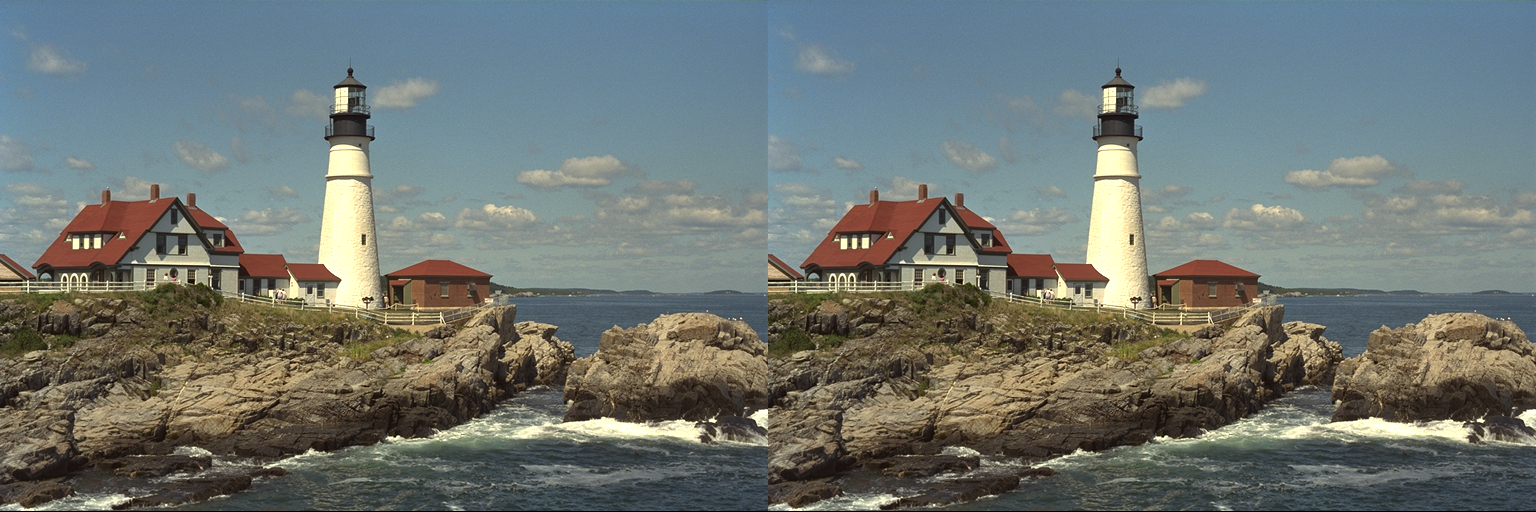

In [151]:
[convert(Array{RGB{Float64}}, img) RGB{Float64}.(img)]

In [215]:
img_blurred = Array{RGB{Float64}}(size(img))
kernel_size = 10;
kernel = generate_gaussian_kernel(1, coord(kernel_size, kernel_size));
for x in 1:size(img_blurred, 1) - kernel_size
    for y in 1:size(img_blurred, 2) - kernel_size
        # convolve the kernel with the image segment.
        # the .* operator is element-wise multiplication
        # as opposed to the * operator that is
        # matrix multiplication
        img_blurred[x, y] = sum(RGB{Float64}.(
            @view img[x:x+kernel_size-1, y:y+kernel_size-1]) .* kernel)
    end
end

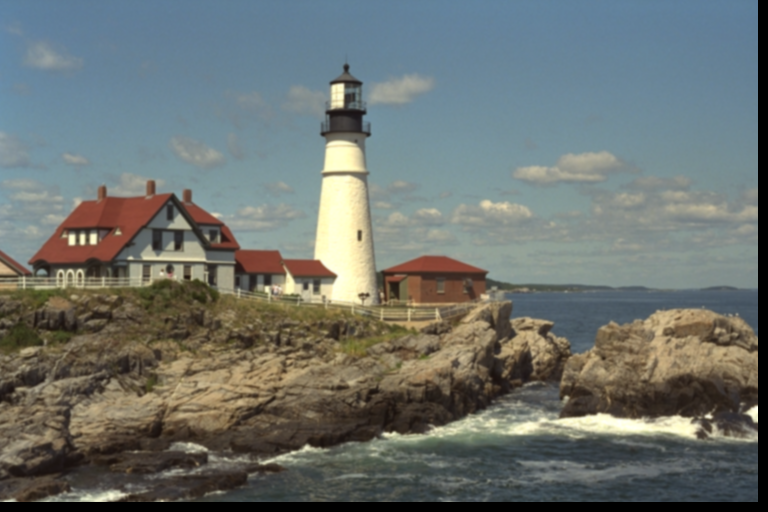

In [216]:
img_blurred

The black pixels on the edges of the image don't have exactly kernel-size matches in the input image, so for now I am just not not computing those pixels. The way I do this is by modifying the `for` loop to not iterate over the last pixels. The right way to fix this is to implement an "out of bounds" function to access pixels outside the range of an image.